In [1]:
import io
import shutil
import requests
import pandas as pd
import numpy as np
import csv
import glob
import os
from sklearn import linear_model
from datetime import datetime

def mask(df, key, value):
    return df[df[key] == value]

## Import of Delay Data

In [2]:
listpaths = ['https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/03ec9d0a-b16f-4e78-8e4f-2da4970efbb6/download/fahrzeiten_soll_ist_20180325_20180331.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/c88a3801-c6fc-4d32-8ece-e269899be497/download/fahrzeiten_soll_ist_20180318_20180324.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/eb403fd1-8f8b-475e-98aa-f04ee3b255ba/download/fahrzeiten_soll_ist_20180311_20180317.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/1ac13127-fcde-4ac2-8462-50f348fd28fe/download/fahrzeiten_soll_ist_20180218_20180224.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/97e59d2a-83ec-438f-ae6f-0fe85d9bc1e6/download/fahrzeiten_soll_ist_20180304_20180310.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/b45b383e-4b0d-4ad0-8bee-e958c5e7360a/download/fahrzeiten_soll_ist_20180121_20180127.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/f17a950d-5be5-4b00-bafd-3c859afcc6cc/download/fahrzeiten_soll_ist_20180204_20180210.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/a38c5d0f-b732-4f5a-9786-eb01a2ffa0bb/download/fahrzeiten_soll_ist_20180211_20180217.csv']
frame = pd.DataFrame()
list_ = []
for path_ in listpaths:
    df = pd.read_csv(path_,index_col=None)
    list_.append(df)
df = pd.concat(list_)
# check size
check = pd.DataFrame(data=df)
col = check.shape[1]
row = check.shape[0]
print(row)
print(col)
# print(df)
print(df.head())
# for i in range(2):
#     s = requests.get(path.i).content
#     c = pd.read_csv(glob.glob(io.StringIO(s.decode('utf-8')[0]), index_col=None)
#     df = pd.DataFrame(data=c)

11176038
34
   linie  richtung betriebsdatum  fahrzeug  kurs  seq_von  halt_diva_von  \
0      2         1      25.03.18      2084     6        1           6030   
1      2         1      25.03.18      3009     3        1            478   
2      2         1      25.03.18      3009     3        5            601   
3      2         1      25.03.18      3009     3        4           1861   
4      2         1      25.03.18      3009     3        3           2396   

   halt_punkt_diva_von halt_kurz_von1 datum_von         ...          \
0                    0           DEP4  25.03.18         ...           
1                    0           BEZI  25.03.18         ...           
2                    0           BOES  25.03.18         ...           
3                    0           PARA  25.03.18         ...           
4                    0           SIHS  25.03.18         ...           

   fahrweg_id  fw_no  fw_typ  fw_kurz                   fw_lang  umlauf_von  \
0       65662     15     

## Time difference calculation and formatting

In [3]:
df.drop(df.columns[[3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]], axis=1, inplace=True)
pd.DataFrame.mask = mask
df = df.mask('linie',69)
check = pd.DataFrame(data=df)
col = check.shape[1]
row = check.shape[0]
print(row)
print(col)
df.loc[:,'diff'] = (df['ist_an_von'] - df['soll_an_von'])
dp = df.copy()
dp.reset_index(drop=True, inplace=True)
dp.loc[:,'time'] = dp.loc[:,'soll_an_von'].copy().astype(float)
dp.loc[:,'time'] = pd.to_datetime(dp.loc[:,'time'], errors='coerce', unit='s')
dp.loc[:,'time'] = dp.loc[:,'time'].dt.strftime('%H:%M')
df1 = dp.copy()
df1.drop(dp.columns[[3, 4]], axis=1, inplace=True)
df1['time'] = pd.to_datetime(df1['betriebsdatum'] + ' ' + df1['time'])
df1.drop(df1.columns[[2]],axis=1, inplace = True)
df1.loc[:,'diff'] = df1.loc[:,'diff'].apply(pd.to_numeric, errors='coerce',downcast='float')
df1.loc[:,'time'] = df1.loc[:,'time'].dt.round('60min') 
df1 = df1[pd.notnull(df1.loc[:,'diff'])]

print(df1.head())
print(df1.dtypes)

124096
5
   linie  richtung  diff       time
0     69         2   -55 2018-03-25
1     69         2   -50 2018-03-25
2     69         2   -32 2018-03-25
3     69         2   -33 2018-03-25
4     69         2   -16 2018-03-25
linie                int64
richtung             int64
diff                 int64
time        datetime64[ns]
dtype: object


## Import of Weather Data .csv

In [7]:
#turn off warnings
pd.options.mode.chained_assignment = None
#input folder
path = r'./weather/*.csv'
#import csv as dataframe
new_cols = ['weather']
we = pd.read_csv(glob.glob('./weather/*.csv')[0], header=None, names = new_cols)
wet1 = pd.DataFrame(data = we)
#clean-up
wet = wet1.iloc[3:]
wet.loc[:,'time'] = wet.weather.str.split(';').str.get(0)
wet.loc[:,'rain'] = wet.weather.str.split(';').str.get(1) 
wet.drop(wet.columns[[0]], axis=1, inplace = True)
wet.loc[:,'time'] = pd.to_datetime(wet.loc[:,'time'])
wet.loc[:,'rain'] = wet.loc[:,'rain'].apply(pd.to_numeric, errors='coerce')
wet = wet[pd.notnull(wet.loc[:,'rain'])]

q = wet.shape[1]
o = wet.shape[0]
print('Number of columns: %d'%q)
print('Number of rows: %d'%o)   
print(wet.head())
print(wet.dtypes)

Number of columns: 2
Number of rows: 7040
                 time  rain
3 2017-03-31 00:00:00   0.0
4 2017-03-31 01:00:00   0.0
5 2017-03-31 02:00:00   0.0
6 2017-03-31 03:00:00   0.0
7 2017-03-31 04:00:00   0.0
time    datetime64[ns]
rain           float64
dtype: object


## Matching Rain and Time Difference

In [30]:
# def nearest(items, pivot):
#     return min(items, key=lambda x: abs(x - pivot))
# df1.apply(nearest(wet.loc[:,'time'],df1.loc[:,'time']))
# df1.set_index(df1.loc[:,'time'], inplace=True)
# wet.set_index(wet.loc[:,'time'], inplace=True)

# print(df1.head())
# print(wet.head())

# left merge on both time col which are in datetime format
merge = df1.merge(wet, left_on='time', right_on='time', how='left')
merge = merge.dropna(how='any') 
merge[['diff','rain']] = merge[['diff','rain']].astype(int)
                          
print(merge.head(3))
print(merge.dtypes)
# df1.iloc[df1.index.get_loc(wet.loc[:,'time'],method='nearest')]
# df1['time'] = pd.DatetimeIndex(wet['time']).normalize()
# df1.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
# pred = pd.merge(df1, wet).head()


   linie  richtung  diff       time  rain
0     69         2   -55 2018-03-25     0
1     69         2   -50 2018-03-25     0
2     69         2   -32 2018-03-25     0
linie                int64
richtung             int64
diff                 int64
time        datetime64[ns]
rain                 int64
dtype: object


## Prediction

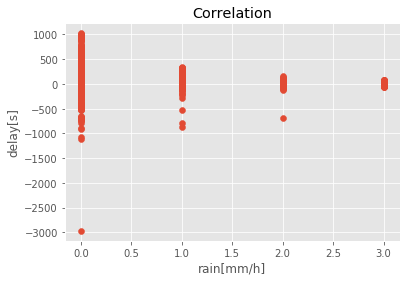

count    121675.000000
mean          0.070655
std           0.283824
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: rain, dtype: float64
count    121675.000000
mean         31.902601
std          61.468148
min       -2972.000000
25%           0.000000
50%          21.000000
75%          48.000000
max        1025.000000
Name: diff, dtype: float64
r-squared: 0.00011254594188023432


In [34]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
import scipy
from scipy import stats
import numpy

x = merge.loc[:,'rain']
y = merge.loc[:,'diff']

# output folder
newpath = r'./output/'
if os.path.exists(newpath):
    shutil.rmtree(newpath, ignore_errors=True)
os.makedirs(newpath)
plt.scatter(x,y)
plt.title("Correlation")
plt.xlabel("rain[mm/h]")
plt.ylabel("delay[s]")
plt.savefig('./output/plot.png', format='png', dpi=1200)
plt.show()

print(merge.loc[:,'rain'].describe())
print(merge.loc[:,'diff'].describe())

slope, intercept, r_value, p_value, std_err = stats.linregress(merge.loc[:,'rain'], merge.loc[:,'diff'])
print("r-squared:", r_value**2)


# X = merge.loc[:,['diff','rain']]
# y = merge.loc[:,'rain']
# from sklearn.svm import SVC
# clf = SVC()
# np.any(np.isnan(merge.loc[:,['diff','rain']]))
# clf.fit(X, y)
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#     max_iter=-1, probability=False, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)
# print(clf.predict([[-0.8, -1]]))

# x_train = merge.loc[:,'rain']
# y_train = merge.loc[:,'diff']
# x_test = merge.loc[:,'rain']

# linear = linear_model.LinearRegression()
# linear.fit(x_train, y_train)
# linear.score(x_train, y_train)
# print('Coefficient: \n', linear.coef_)
# print('Intercept: \n', linear.intercept_)
# predicted= linear.predict(x_test)

## Output